In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image
import tensorflow as tf
from numba import cuda

device = cuda.get_current_device()

In [2]:
def create_point_map_np(x, y, real_origin, imag_origin, frame_size):
    ratio = y/x
    real_start = real_origin - (frame_size/2)
    imag_start = imag_origin - (ratio*frame_size/2)
    real_stop = real_origin + (frame_size/2)
    imag_stop = (imag_origin + (ratio*frame_size/2))
    real_step = frame_size/x
    imag_step = frame_size/x
    
    real_arr_1d = np.arange(real_start, real_stop, real_step)
    imag_arr_1d = np.arange(imag_start, imag_stop, imag_step)
    
    real_arr = np.zeros((real_arr_1d.shape[0], imag_arr_1d.shape[0]))
    for i in range(imag_arr_1d.shape[0]):
        real_arr[:,i] = real_arr_1d
    imag_arr = np.zeros((real_arr_1d.shape[0], imag_arr_1d.shape[0]))
    for j in range(real_arr_1d.shape[0]):
        imag_arr[j,:] = imag_arr_1d
    
    
    point_map = (real_arr + imag_arr * 1j).T
    return point_map.T

def create_image_array_np(point_map, num_iter, max_dist):
    
    zeros = np.zeros((point_map.shape[0], point_map.shape[1]))
    ones = np.ones((point_map.shape[0], point_map.shape[1]))
    point_map_orig = np.array(point_map, copy=True)
    for i in range(num_iter):
        point_map = (point_map * point_map) + point_map_orig
    abs_arr = np.abs(point_map)
    set_arr = np.where(abs_arr <= max_dist, ones, zeros)
    return set_arr

In [3]:
def generate_set_image_np(x, y, real_origin, imag_origin, frame_size, num_iter, max_dist):
    ratio = y/x
    real_start = real_origin - (frame_size/2)
    imag_start = imag_origin - (ratio*frame_size/2)
    real_stop = real_origin + (frame_size/2)
    imag_stop = (imag_origin + (ratio*frame_size/2))
    real_step = frame_size/x
    imag_step = frame_size/x
    
    real_arr_1d = np.arange(real_start, real_stop, real_step)
    imag_arr_1d = np.arange(imag_start, imag_stop, imag_step)
    
    real_arr = np.zeros((real_arr_1d.shape[0], imag_arr_1d.shape[0]))
    for i in range(imag_arr_1d.shape[0]):
        real_arr[:,i] = real_arr_1d
    imag_arr = np.zeros((real_arr_1d.shape[0], imag_arr_1d.shape[0]))
    for j in range(real_arr_1d.shape[0]):
        imag_arr[j,:] = imag_arr_1d
    
    
    point_map = (real_arr + imag_arr * 1j).T
    
    zeros = np.zeros((point_map.shape[0], point_map.shape[1]))
    ones = np.ones((point_map.shape[0], point_map.shape[1]))
    point_map_orig = np.array(point_map, copy=True)
    for i in range(num_iter):
        point_map = (point_map * point_map) + point_map_orig
    abs_arr = np.abs(point_map)
    set_arr = np.where(abs_arr <= max_dist, ones, zeros)
    return set_arr

In [8]:
def create_point_map_tf(x, y, real_origin, imag_origin, frame_size):
    ratio = y/x
    real_start = real_origin - (frame_size/2)
    imag_start = imag_origin - (ratio*frame_size/2)
    real_stop = real_origin + (frame_size/2)
    imag_stop = (imag_origin + (ratio*frame_size/2))
    real_step = frame_size/x
    imag_step = frame_size/x
    
    with tf.device("/GPU:0"):
        real_arr_1d = tf.range(real_start, real_stop, real_step)
        real_arr_1d = tf.constant(tf.reshape(real_arr_1d, (1,real_arr_1d.shape[0])))
        imag_arr_1d = tf.range(imag_start, imag_stop, imag_step)
        imag_arr_1d = tf.constant(tf.reshape(imag_arr_1d, (1,imag_arr_1d.shape[0])))
        
        real_tile = tf.constant([1,imag_arr_1d.shape[0]])
        real_arr = tf.tile(real_arr_1d, real_tile)
        
        imag_tile = tf.constant([1,real_arr_1d.shape[0]])
        imag_arr = tf.tile(imag_arr_1d, imag_tile)
        
    
        point_map = tf.complex(real_arr, tf.transpose(imag_arr))
        return point_map

def create_image_array_tf(point_map, num_iter, max_dist):
    with tf.device('/GPU:0'):
        zeros = tf.zeros((point_map.shape[0], point_map.shape[1]))
        ones = tf.ones((point_map.shape[0], point_map.shape[1]))
        point_map_orig = tf.raw_ops.Copy(input=point_map)
        for i in range(num_iter):
            point_map = tf.math.accumulate_n([tf.math.multiply(point_map, point_map),point_map_orig])
        abs_arr = tf.math.abs(point_map)
        set_arr = tf.where(abs_arr <= max_dist, ones, zeros)
        return set_arr.numpy()




In [9]:
def generate_set_image_tf(x, y, real_origin, imag_origin, frame_size, num_iter, max_dist):
    ratio = y/x
    real_start = real_origin - (frame_size/2)
    imag_start = imag_origin - (ratio*frame_size/2)
    real_stop = real_origin + (frame_size/2)
    imag_stop = (imag_origin + (ratio*frame_size/2))
    real_step = frame_size/x
    imag_step = frame_size/x
    
    with tf.device("/GPU:0"):
        real_arr_1d = tf.range(real_start, real_stop, real_step)
        real_arr_1d = tf.constant(tf.reshape(real_arr_1d, (1,real_arr_1d.shape[0])))
        imag_arr_1d = tf.range(imag_start, imag_stop, imag_step)
        imag_arr_1d = tf.constant(tf.reshape(imag_arr_1d, (1,imag_arr_1d.shape[0])))
        
        real_tile = tf.constant([1,imag_arr_1d.shape[0]])
        real_arr = tf.tile(real_arr_1d, real_tile)
        
        imag_tile = tf.constant([1,real_arr_1d.shape[0]])
        imag_arr = tf.tile(imag_arr_1d, imag_tile)
        
    
        point_map = tf.complex(real_arr, tf.transpose(imag_arr))
        
        
        zeros = tf.zeros((point_map.shape[0], point_map.shape[1]))
        ones = tf.ones((point_map.shape[0], point_map.shape[1]))
        point_map_orig = tf.raw_ops.Copy(input=point_map)
        for i in range(num_iter):
            point_map = tf.math.accumulate_n([tf.math.multiply(point_map, point_map),point_map_orig])
        abs_arr = tf.math.abs(point_map)
        set_arr = tf.where(abs_arr <= max_dist, ones, zeros)
        return set_arr.numpy()

In [8]:
device.reset()

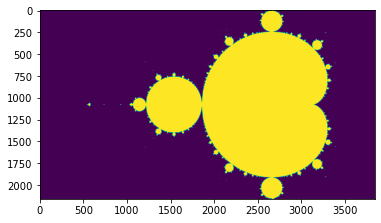

In [12]:
width = 3840
height = 2160
real_origin = -.7
imag_origin = 0
frame_size = 3
num_iter = 1000
max_dist = 4

set_arr = generate_set_image_tf(width, height, real_origin, imag_origin, frame_size, num_iter, max_dist)
plt.imshow(set_arr)


In [7]:
def in_set_color(c, num_iter, max_dist):
    z = c
    i = 0
    while i < num_iter:
        z = (z*z) + c
        if np.abs(z) >= max_dist:
            break
        i += 1
    if i > num_iter/2:
        return i/num_iter
    else:
        return 0
    

    
def create_image_array_color(x, y, real_origin, imag_origin, frame_size, num_iter, max_dist):
    arr = np.zeros((y, x,3))
    
    ratio = y/x
    
    complex_multiplier = 1j
    for i in range(x):
        for j in range(y):
            t1 = ((i+1)/x)*frame_size - (frame_size/2) + real_origin
            t2 = (((((j+1)/y)*frame_size - (frame_size/2))*ratio) + imag_origin)*complex_multiplier
            color = in_set_color(t1+t2, num_iter, max_dist)
            arr[j,i,1] = 1-color
            arr[j,i,2] = color
            
    return arr



def create_point_map_color(x, y, real_origin, imag_origin, frame_size):
    arr = np.zeros((x, y, 3), dtype=complex)
    ratio = y/x
    
    complex_multiplier = 1j
    for i in range(x):
        for j in range(y):
            t1 = ((i+1)/x)*frame_size - (frame_size/2) + real_origin
            t2 = (((((j+1)/y)*frame_size - (frame_size/2))*ratio) + imag_origin)*complex_multiplier
            arr[i,j,0] = t1+t2
    return arr.T


def create_image_array_color_np(point_map, num_iter, max_dist):
    zeros = np.zeros((point_map.shape[0], point_map.shape[1],3))
    red = np.array([[[1,0,0]]*point_map.shape[0]]*point_map.shape[1])
    yellow = np.array([[[1,1,0]]*point_map.shape[0]]*point_map.shape[1])
    purple = np.array([[[1,0,1]]*point_map.shape[0]]*point_map.shape[1])
    print(red.shape)
    print(yellow.shape)
    print(purple.shape)
    point_map_orig = np.array(point_map, copy=True)
    for i in range(num_iter):
        point_map = (point_map * point_map) + point_map_orig
    
    abs_arr = np.abs(point_map)
    
    purple_cutoff = max_dist/3
    red_cutoff = 2*max_dist/3
    yellow_cutoff = max_dist
    set_arr = np.zeros((point_map.shape))
    set_arr = np.where(abs_arr <= purple_cutoff, [1,0,1], [0,0,0])
    set_arr = np.where(abs_arr > purple_cutoff and abs_arr <= red_cutoff, red, set_arr)
    set_arr = np.where(abs_arr > red_cutoff and abs_arr <= yellow_cutoff, yellow, set_arr)
    return set_arr

In [8]:
def generate_set_image_color_tf(x, y, real_origin, imag_origin, frame_size, num_iter, max_dist, colors):
    ratio = y/x
    real_start = real_origin - (frame_size/2)
    imag_start = imag_origin - (ratio*frame_size/2)
    real_stop = real_origin + (frame_size/2)
    imag_stop = (imag_origin + (ratio*frame_size/2))
    real_step = frame_size/x
    imag_step = frame_size/x
    
    with tf.device("/GPU:0"):
        real_arr_1d = tf.range(real_start, real_stop, real_step)
        real_arr_1d = tf.constant(tf.reshape(real_arr_1d, (1,real_arr_1d.shape[0])))
        imag_arr_1d = tf.range(imag_start, imag_stop, imag_step)
        imag_arr_1d = tf.constant(tf.reshape(imag_arr_1d, (1,imag_arr_1d.shape[0])))
        
        real_tile = tf.constant([1,imag_arr_1d.shape[0]])
        real_arr = tf.tile(real_arr_1d, real_tile)
        
        imag_tile = tf.constant([1,real_arr_1d.shape[0]])
        imag_arr = tf.tile(imag_arr_1d, imag_tile)
        
    
        point_map = tf.complex(real_arr, tf.transpose(imag_arr))
        
        point_map_orig = tf.raw_ops.Copy(input=point_map)
        for i in range(num_iter):
            point_map = tf.math.accumulate_n([tf.math.multiply(point_map, point_map),point_map_orig])
        
        
        
        abs_arr = tf.math.abs(point_map)
        abs_arr = tf.reshape(abs_arr, (abs_arr.shape[0], abs_arr.shape[1],1))
        tile = tf.constant([1,1,3])
        abs_arr = tf.tile(abs_arr, tile)
        
        background = colors.pop()
        set_arr = tf.constant([[background]*point_map.shape[1]]*point_map.shape[0], dtype=tf.float32)
        color_cutoffs = []
        color_tensors = []
        for j,color in enumerate(colors):
            color_cutoffs.append(int(max_dist*((j+1)/len(colors))))
            color_tensors.append(tf.constant([[color]*point_map.shape[1]]*point_map.shape[0]))
        for k in range(len(colors)-1,0, -1):
            set_arr = tf.where(abs_arr <= color_cutoffs[k], color_tensors[k], set_arr)
            
        
        
        return set_arr.numpy()

In [53]:
frame1 = (-.7,0,4)
frame2 = (-.705, .246,  0.005)

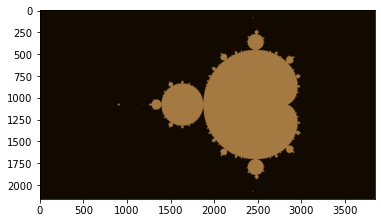

In [54]:
width = 3840
height = 2160
real_origin, imag_origin, frame_size = frame1
num_iter = 1100
max_dist = 30

colors = [
    [0.,0.,0.],
    [165.,122.,66.],
    [18.,9.,0.]
    
]




set_arr = generate_set_image_color_tf(width, height, real_origin, imag_origin, frame_size, num_iter, max_dist, colors)
plt.imshow(set_arr/255)

In [16]:
image_number = 10

In [55]:
set_arr = set_arr
picture = Image.fromarray(set_arr.astype(np.uint8))
picture.save('mandelbrot{}.png'.format(image_number))
image_number += 1

In [2]:
def change_image_color(image, colors):
    image = np.asarray(Image.open(image))
    rgb_image = np.zeros((image.shape[0], image.shape[1], 3))
    for i in range(3):
        rgb_image[:,:,i] = image
    c1 = np.zeros((image.shape[0], image.shape[1], 3))
    c2 = np.zeros((image.shape[0], image.shape[1], 3))
    c1[:,:,0], c1[:,:,1], c1[:,:,2] = tuple(colors[0])
    c2[:,:,0], c2[:,:,1], c2[:,:,2] = tuple(colors[1])
    rgb_image = np.where(rgb_image == 255, c1, c2)
    return rgb_image

In [15]:
color = [[255,128,0],[204,0,204]]

new_img = change_image_color("mandelbrot7.jpeg", color)


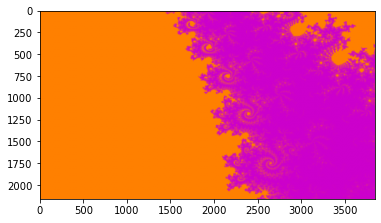

In [16]:
plt.imshow(new_img/255)